# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [1]:
GROUP_NO = 100 # group number
GROUP_MEMBERS = {
    419866: "Shiyao Ju", # mat. no. : name,
    449970: "Shuo Sun",
    433193: "Yujie Chen",
}

---

In [2]:
# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (7.5 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [3]:
# Import and visualization.

swift_df = pd.read_csv('./datasets/q4_taylor_swift.csv')
display(swift_df.head())

album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck

ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [4]:
def encode_with_unicode(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    cleaned_text = normalized_text.replace('(', '').replace(')', '')
    return cleaned_text

swift_df['album'] = swift_df['album'].apply(encode_with_unicode)
swift_df['lyric'] = swift_df['lyric'].apply(encode_with_unicode)

display(swift_df)

album                                        lyric
0                Taylor Swift          He said the way my blue eyes shined
1                Taylor Swift  Put those Georgia stars to shame that night
2                Taylor Swift                       I said, "That's a lie"
3                Taylor Swift                  Just a boy in a Chevy truck
4                Taylor Swift         That had a tendency of gettin' stuck
...                       ...                                          ...
8324  evermore deluxe version       You know, you know, you know, you know
8325  evermore deluxe version                         When it's time to go
8326  evermore deluxe version                               So then you go
8327  evermore deluxe version                                  Then you go
8328  evermore deluxe version                                  You just go

[8329 rows x 2 columns]

### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [5]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """

    album_lyrics_count = input_df.groupby('album')['lyric'].count()
    
    return album_lyrics_count

In [6]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})

album  lyric count
0                1989 Deluxe         1003
1  Fearless Taylor’s Version         1170
2                      Lover          932
3         Red Deluxe Edition         1064
4           Speak Now Deluxe          935
5               Taylor Swift          609
6    evermore deluxe version          909
7    folklore deluxe version          722
8                 reputation          985

### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [7]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    
    input_series.sort_values(ascending=False).plot(kind='bar')
    
    plt.title('Lyric Count per Album')
    plt.xlabel('Album')
    plt.ylabel('Lyric Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

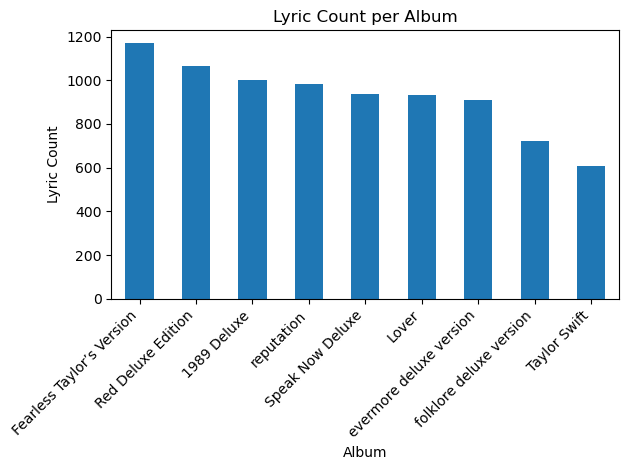

In [8]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer:__ No, the data is not balanced enough for album classification.

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

In [10]:
# Dropping all duplicates of a lyric on an album

swift_df_proc = swift_df.drop_duplicates(subset=['album', 'lyric'])
display(swift_df_proc.shape)

(5559, 2)

ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

In [ ]:
lyrics_multiple_albums = swift_df_proc[swift_df_proc.duplicated(subset='lyric', keep=False)]
swift_df_proc = swift_df_proc[~swift_df_proc['lyric'].isin(lyrics_multiple_albums['lyric'])]

display(lyrics_multiple_albums)

album  \
216                Taylor Swift   
312                Taylor Swift   
491                Taylor Swift   
614   Fearless Taylor’s Version   
631   Fearless Taylor’s Version   
743   Fearless Taylor’s Version   
796   Fearless Taylor’s Version   
871   Fearless Taylor’s Version   
1685  Fearless Taylor’s Version   
1710  Fearless Taylor’s Version   
1823           Speak Now Deluxe   
1972           Speak Now Deluxe   
2236           Speak Now Deluxe   
2936         Red Deluxe Edition   
3114         Red Deluxe Edition   
3140         Red Deluxe Edition   
3294         Red Deluxe Edition   
3588         Red Deluxe Edition   
3829                1989 Deluxe   
4379                1989 Deluxe   
4381                1989 Deluxe   
4414                1989 Deluxe   
4540                1989 Deluxe   
4554                1989 Deluxe   
4831                 reputation   
5828                      Lover   
6134                      Lover   
6610                      Lover   
6716    folklore deluxe version   
7383    folklore deluxe version   
7800    evermore deluxe version   
7806    evermore deluxe version   
8008    evermore deluxe version   

                                                  lyric  
216                                            Oh, yeah  
312                                      Oh, oh, oh, oh  
491                                            With you  
614                                            Oh, yeah  
631                                              Oh, oh  
743                                          Oh, oh, oh  
796                                            Oh-oh-oh  
871                          In the middle of the night  
1685                                         And I said  
1710                                         Ah, ah, ah  
1823                                         Yeah, yeah  
1972                                           Ooh, ooh  
2236  Nardo Wick 'Who Want Smoke??' Live Performance...  
2936                                         Oh, oh, oh  
3114                                           Oh-oh-oh  
3140                                         And I said  
3294  Nardo Wick 'Who Want Smoke??' Live Performance...  
3588                                       Oh-oh, oh-oh  
3829                                                Ayy  
4379                                         Oh, oh, oh  
4381                                       Oh-oh, oh-oh  
4414                                         Yeah, yeah  
4540                                     Oh, oh, oh, oh  
4554                                             Oh, oh  
4831                         In the middle of the night  
5828                                           With you  
6134                                                Ayy  
6610                                                Ooh  
6716                                                Ooh  
7383                                         Ah, ah, ah  
7800                                           Ooh, ooh  
7806                                                Ooh  
8008                                         Yeah, yeah

__Student Answer:__ Yes, lyrics occur in several albums. The exact lyrics are shown above.

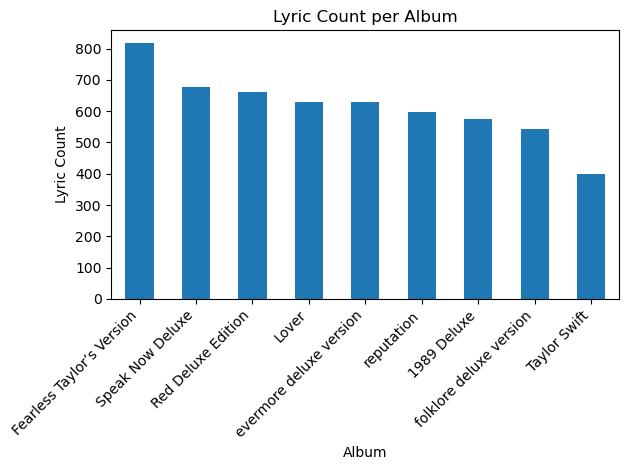

album
1989 Deluxe                  574
Fearless Taylor’s Version    818
Lover                        629
Red Deluxe Edition           660
Speak Now Deluxe             678
Taylor Swift                 399
evermore deluxe version      629
folklore deluxe version      542
reputation                   597
Name: lyric, dtype: int64

In [ ]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [ ]:
# Creating the corpus

corpus = swift_df_proc['lyric'].tolist()

print(corpus)

['He said the way my blue eyes shined', 'Put those Georgia stars to shame that night', 'I said, "That\'s a lie"', 'Just a boy in a Chevy truck', "That had a tendency of gettin' stuck", 'On back roads at night', 'And I was right there beside him all summer long', 'And then the time we woke up to find that summer gone', 'But when you think Tim McGraw', 'I hope you think my favorite song', 'The one we danced to all night long', 'The moon like a spotlight on the lake', 'When you think happiness', 'I hope you think that little black dress', 'Think of my head on your chest', 'And my old faded blue jeans', 'When you think Tim McGraw', 'I hope you think of me', 'September saw a month of tears', "And thankin' God that you weren't here", 'To see me like that', 'But in a box beneath my bed', 'Is a letter that you never read', 'From three summers back', "It's hard not to find it all a little bittersweet", "And lookin' back on all of that, it's nice to believe", "And I'm back for the first time sin

### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

In [ ]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    tokens = reg_tokenizer.tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopword_list]
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(token) for token in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [ ]:
# Corpus preprocessing

corpus_proc = [preprocessor_func(lyric) for lyric in corpus]

print(corpus_proc)

['said way blue eye shined', 'put georgia star shame night', 'said lie', 'boy chevy truck', 'tendency gettin stuck', 'back road night', 'right beside summer long', 'time woke find summer gone', 'think tim mcgraw', 'hope think favorite song', 'one danced night long', 'moon like spotlight lake', 'think happiness', 'hope think little black dress', 'think head chest', 'old faded blue jean', 'think tim mcgraw', 'hope think', 'september saw month tear', 'thankin god', 'see like', 'box beneath bed', 'letter never read', 'three summer back', 'hard find little bittersweet', 'lookin back nice believe', 'back first time since', 'standin street', 'letter left doorstep', 'first thing read', 'think tim mcgraw', 'someday turn radio', 'hope take back place', 'oh think', 'mmmm', 'state obvious get perfect fantasy', 'realize love could ever love', 'go tell friend obsessive crazy', 'fine tell mine gay', 'way', 'hate stupid old pickup truck', 'never let drive', 'redneck heartbreak', 'really bad lying', 'w

### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [ ]:
X = swift_df_proc.drop(columns=['album'])
y = swift_df_proc['album']

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [ ]:
corpus_train = df_train['lyric'].tolist()
corpus_test = df_test['lyric'].tolist()

## Set of Words (6 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [ ]:
sow = CountVectorizer(binary=True, preprocessor=preprocessor_func)
corpus_vectors = sow.fit(corpus)

### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [ ]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    
    chosen_lyric = swift_df.iloc[index]['lyric']
    preprocessed_lyric = preprocessor_func(chosen_lyric)
    sow_representation = sow.transform([corpus[index]]).toarray()
    
    return chosen_lyric, preprocessed_lyric, sow_representation    

In [ ]:
index = 1

In [ ]:
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      Put those Georgia stars to shame that night
Preprocessed line:  put georgia star shame night
SoW encoding:
 [[0 0 0 ... 0 0 0]]


__Student Answer:__ The primary information encoded is whether a particular word is present or absent in the document. Each word is typically encoded as a binary feature, with a value of 1 if the word is present and 0 if it is absent. The size of the set directly corresponds to the vocabulary size, representing the unique words present in the document.

### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [ ]:
# Creating the set of words encoding

sow_from_train = CountVectorizer(preprocessor=preprocessor_func)
sow_from_train.fit(corpus_train)

X_train = sow_from_train.transform(corpus_train)
X_test = sow_from_train.transform(corpus_test)

In [ ]:
# Train the classifier

classifier = SGDClassifier(loss='log_loss')
classifier.fit(X=X_train, y=y_train)

SGDClassifier(loss='log_loss')

In [ ]:
# Predict the album

predictions_train = classifier.predict(X_train)
predictions_test = classifier.predict(X_test)

In [ ]:
# Compute and show accuracy for training and test set

accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)

print(f"Accuracy on Training Set: {accuracy_train:.4f}")
print(f"Accuracy on Test Set: {accuracy_test:.4f}")

Accuracy on Training Set: 0.7672
Accuracy on Test Set: 0.3156


### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **a4)** to support your argument. 

__Student Answer:__ A most frequent guessing classifier always predicts the most frequent class (album) in the dataset.
Its accuracy is determined by the proportion of the most frequent class in the dataset. By looking at the distribution of the lyrics we can see that if we use most frequent guessing classifier the accuracy will be around 0.15. Thus the accuracy of our predictions is greatly improved by the SGDClassifier.

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **b3)**.

In [ ]:
def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """

    lyric = swift_df.iloc[index]['lyric']
    actual_album = swift_df.iloc[index]['album']
    sow = CountVectorizer(preprocessor=preprocessor_func)
    sow.fit(corpus)
    X = sow.transform(corpus)
    classifier = SGDClassifier(loss='log_loss')
    classifier.fit(X=X, y=y)
    predictions = classifier.predict(X)

    return lyric, actual_album, predictions[index]

In [ ]:
index = 1 # Please change the index and do not use -1

In [ ]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           Put those Georgia stars to shame that night
Actual album:    Taylor Swift
Predicted album: Taylor Swift


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set the vector dimension to 20 and min_count to 3.

In [ ]:
# Calculating the number of cores available
cores = multiprocessing.cpu_count()

corpus_p = []
for doc in corpus:
    doc_p = preprocessor_func(doc)
    corpus_p.append(doc_p)

docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_p)]
doc2vec = Doc2Vec(vector_size=20, min_count=3, workers=cores)   
doc2vec.build_vocab(docs)
doc2vec.train(corpus_iterable=docs, total_examples=doc2vec.corpus_count, epochs=100)

### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [ ]:
lyric_embeddings = [doc2vec.infer_vector(reg_tokenizer.tokenize(doc)) for doc in corpus]

### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

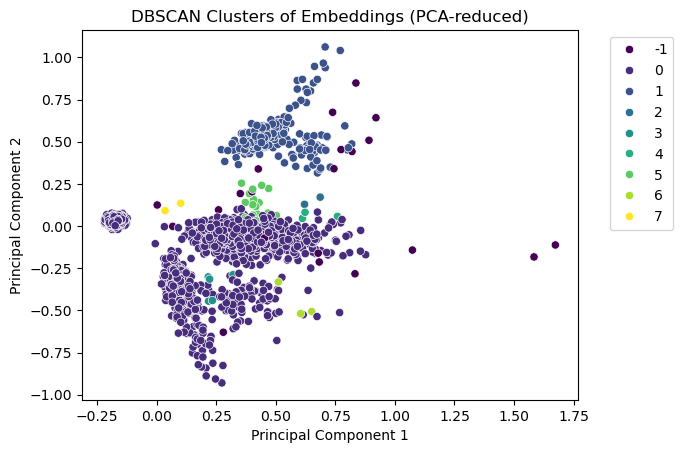

In [ ]:
embeddings_df = pd.DataFrame(lyric_embeddings)

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
embeddings_pca = pca.fit_transform(embeddings_df)

dbscan = DBSCAN(eps=0.3, min_samples=2)
clusters = dbscan.fit_predict(embeddings_df)

embeddings_pca_df = pd.DataFrame(embeddings_pca, columns=['PC1', 'PC2'])
embeddings_pca_df['Cluster'] = clusters

sns.scatterplot(x='PC1', y='PC2', data=embeddings_pca_df, hue='Cluster', palette='viridis', legend='full')
plt.title('DBSCAN Clusters of Embeddings (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

In [ ]:
# Lyrics contained in one cluster

cluster_1_indices = embeddings_pca_df[embeddings_pca_df['Cluster'] == 4].index
swift_df_cluster_1 = swift_df.loc[cluster_1_indices]
display(swift_df_cluster_1)

album                                              lyric
551         Taylor Swift  Why would you wanna break a perfectly good heart?
3174  Red Deluxe Edition                   Just like all those times before
4558         1989 Deluxe                              Oh, oh, oh, oh, oh-oh

In [ ]:
# Lyrics contained in one cluster

cluster_2_indices = embeddings_pca_df[embeddings_pca_df['Cluster'] ==3].index
swift_df_cluster_2 = swift_df.loc[cluster_2_indices]
display(swift_df_cluster_2)

album  \
410                Taylor Swift   
1321  Fearless Taylor’s Version   
1532  Fearless Taylor’s Version   
3492         Red Deluxe Edition   
4631                1989 Deluxe   

                                                 lyric  
410     When we're on the phone and you talk real slow  
1321  And I stare at the phone, he still hasn't called  
1532                             Held out, and held on  
3492                       I've got my eye on the door  
4631                                     In Wonderland

__Student Answer:__ The lyrics are similar in this two cluster. Because the clustering algorithm has successfully grouped together lyrics that share similar themes, topics, or sentiments. 

## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [ ]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """
    tokens = lyric.split()
    lowercase_tokens = [token.lower() for token in tokens]
    
    return lowercase_tokens

### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [ ]:
lyrics_column = swift_df['lyric']
lyric_corpus = [lyric_preprocessor(lyric) for lyric in lyrics_column]

print(lyric_corpus)

[['he', 'said', 'the', 'way', 'my', 'blue', 'eyes', 'shined'], ['put', 'those', 'georgia', 'stars', 'to', 'shame', 'that', 'night'], ['i', 'said,', '"that\'s', 'a', 'lie"'], ['just', 'a', 'boy', 'in', 'a', 'chevy', 'truck'], ['that', 'had', 'a', 'tendency', 'of', "gettin'", 'stuck'], ['on', 'back', 'roads', 'at', 'night'], ['and', 'i', 'was', 'right', 'there', 'beside', 'him', 'all', 'summer', 'long'], ['and', 'then', 'the', 'time', 'we', 'woke', 'up', 'to', 'find', 'that', 'summer', 'gone'], ['but', 'when', 'you', 'think', 'tim', 'mcgraw'], ['i', 'hope', 'you', 'think', 'my', 'favorite', 'song'], ['the', 'one', 'we', 'danced', 'to', 'all', 'night', 'long'], ['the', 'moon', 'like', 'a', 'spotlight', 'on', 'the', 'lake'], ['when', 'you', 'think', 'happiness'], ['i', 'hope', 'you', 'think', 'that', 'little', 'black', 'dress'], ['think', 'of', 'my', 'head', 'on', 'your', 'chest'], ['and', 'my', 'old', 'faded', 'blue', 'jeans'], ['when', 'you', 'think', 'tim', 'mcgraw'], ['i', 'hope', 'you

Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [ ]:
padded_tuples, vocab = padded_everygram_pipeline(2, lyric_corpus)
lm_bigram = MLE(2)
lm_bigram.fit(padded_tuples, vocab)

padded_tuples, vocab = padded_everygram_pipeline(3, lyric_corpus)
lm_trigram = MLE(3)
lm_trigram.fit(padded_tuples, vocab)

padded_tuples, vocab = padded_everygram_pipeline(4, lyric_corpus)
lm_fourgram = MLE(4)
lm_fourgram.fit(padded_tuples, vocab)

padded_tuples, vocab = padded_everygram_pipeline(5, lyric_corpus)
lm_fivegram = MLE(5)
lm_fivegram.fit(padded_tuples, vocab)

### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

In [ ]:
def generate_lyrics(n_gram_model, numb_of_new_lyrics: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """

    new_lyric = n_gram_model.generate(numb_of_new_lyrics)
    
    return new_lyric
    

ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

In [ ]:
# Generate and show ten lyrics with the first model

print(generate_lyrics(lm_bigram, 10))

['you', 'think', 'he', 'spends', 'my', 'lips,', 'tongue-tied', '</s>', 'think', 'you']


In [ ]:
# Generate and show ten lyrics with the second model

print(generate_lyrics(lm_fivegram, 10))

['honey,', 'but', 'i', 'cried,', 'cried', 'for', 'you', '</s>', '</s>', '</s>']


__Student Answer:__ In a 2-gram model, each word is generated based on the preceding single word. The context considered is limited to the previous word. In contrast, a 5-gram model considers the preceding four words when generating each word. This difference in context scope has implications for the coherence and contextuality of the generated lyrics. As we saw in the example above, the 5-gram is more in line with natural language